# Student Housing Matchmaker Progress Report
CS 418 Spring 2025
- Cristal Martinez
- Brandon Kim
- Manav Kohli
- Drew Vranicar
- Tyler Yuen

Our Github Notebook: https://github.com/cmart71/Student_Housing_Matchmaker/blob/main/Progress_Report.ipynb


# Project Introduction
Student Housing Matchmaker will be discovering core relations and performing data analysis on apartment listings with respect to preferences (bed, bathrooms, price, etc.) as well traveling options such as biking, CTA busses, and train lines in order to help find the best option for housing for students and their respective schools.

### Discussing Data
In our progress report we will find the corresponding data tables;
- Colleges
    - Dataset containing information of colleges and universities in Chicago
    - Another modified colleges dataset which geocodes and adds latitude and longitude columns
- Rentals
    - Current apartment listings in Chicago as of March 2025 pulled from Zillow.
- Divvy Bike Stations
    - Pickup/Return locations of Divvy bicycle docks
- CTA Bus Routes
    - Dataset of individual CTA bus routes (#57, #12, ....) within Chicago and every stop along that route
- CTA Train Routes
    - Dataset of CTA train lines providing location and availability
- Modified Dataframes
    - Datasets including distances between universities and apartment listings


### Investigating Problems:
- Finding cheap and affordable housing when the main average of listings is higher than the average cost that a student can afford
- How number of bedrooms affect pricing of listings
- Apartment pricing based on location/neighborhood and proximity
- Converting Addresses to Latitude and Longitude
- Using the Haversine forumla to fin distance between two points
- Rent Prediction



# Any changes since the proposal


1. The data for colleges was updated to just handle Chicago colleges. Originally the data included all colleges within Illinois, but was cleaned to soley just include Chicago colleges. This left us with only 70 Chicago colleges to work with.
2. Completed and found the datasets that were needed. During our proposal the CTA datasets were missing. Since then the CTA bus routes and CTA train routes are now included for our project.
3. Many datasets were filtered during data wrangling to contain just the neccessary columns needed. Made the decision to change NaN values found within the Chicago Rentals dataset to 1.0 within baths column as each address contained at least 1 bathroom.
4. Any TRUE/FALSE values found within CTA train routes dataset and changed to type int (1/0).
5. The scope of the project will focus on calculations involving latitude and longitude since cta bus routes, divvy bicycle stations, and train routes don't have an exact address. 

Libary used to calculate latitude and longitude based on address, commented out as csv file is created later on to solve the issue of having to rerun a long task

In [8]:
#%pip install geopy 

# Data

**Colleges dataset**: The data for colleges was updated to just handle Chicago colleges. Originally the data included all colleges within Illinois, but was cleaned to soley just include Chicago colleges. This left us with only 70 Chicago colleges to work with. After filtering to just include Chicago colleges, the dataset was cleaned to just include the important columns needed for our project, which is just to include Name and Address of the Chicago college. (chicago_colleges_df)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded

import time
import requests

from sklearn.cluster import KMeans

In [2]:
il_colleges_df = pd.read_csv("CollegeNavigator_Search_2025-03-03.csv")
print(f"Original database containing total Illinois Universities: {len(il_colleges_df)}")

Original database containing total Illinois Universities: 249


In [3]:
chicago_colleges_df = il_colleges_df[
    il_colleges_df['Address'].str.contains('Chicago', case=False, na=False) &
    ~il_colleges_df['Address'].str.contains('North Chicago', case=False, na=False) &
    ~il_colleges_df['Address'].str.contains('Chicago Heights', case=False, na=False)
]
chicago_colleges_df = chicago_colleges_df[['Name', 'Address']].reset_index(drop=True)
chicago_colleges_df

Name  \
0                            Adler University   
1             American Academy of Art College   
2                    American Islamic College   
3                     Aveda Institute-Chicago   
4   Aviation Institute of Maintenance-Chicago   
..                                        ...   
63     University of Aesthetics & Cosmetology   
64                      University of Chicago   
65             University of Illinois Chicago   
66                 University of Notre Dame -   
67                VanderCook College of Music   

                                              Address  
0   17 North Dearborn Street, Chicago, Illinois 60602  
1    332 S Michigan Ave, Chicago, Illinois 60604-4302  
2       640 W Irving Park RD, Chicago, Illinois 60613  
3            2828 N Clark St, Chicago, Illinois 60657  
4   3711 South Ashland Avenue, Chicago, Illinois 6...  
..                                                ...  
63  1357 N Milwaukee Ave, Chicago, Illinois 60622-...  
64          5801 S Ellis Ave, Chicago, Illinois 60637  
65              601 S Morgan, Chicago, Illinois 60607  
66  224 South Michigan Avenue, Chicago, Illinois 6...  
67  3140 South Federal Street, Chicago, Illinois 6...  

[68 rows x 2 columns]

In [4]:
print(f"Updated/Cleaned database containing total Chicago universities: {len(chicago_colleges_df)}")

Updated/Cleaned database containing total Chicago universities: 68


### Geocoding
To help evaluate distance we'll be adding latitude and longitude to our cleaned database by utilizing geopy and the Nominatim library in order to geocode the addresses and give an approximate location of each university

Note that the following code may produce NaN values as a consequence of Nominatim's Rate Limiting and Usage Policy preventing bulk requests. As an alternative, the following script is used to produce a dataframe of the colleges database with the addition of two columns, Latitude and Longitude.

In order to account for the NaN values, the few remaining entries with NaN values were manually geocoded to get their respective latitude and longitude

If you choose to run it, be aware that you won't get NaN values in the same areas as a side effect of the Usage Policy, therefore, the "chicago_colleges_geocoded.csv" contains everything you need

In [122]:
# from random import randint
# from time import sleep
# user_agent = "user-agent-{}".format(randint(100, 999))

# geolocator = Nominatim(user_agent=user_agent)
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5, max_retries= 0)

# # create copy of dataframe
# chicago_colleges_geocoded_df = chicago_colleges_df

# def get_latlong(address):
#     try:
#         location = geocode(address)
#         if location:
#             return location.latitude, location.longitude
#         return None, None
#     except GeocoderTimedOut:
#         sleep(randint(2*100, 5*100)/100)
#         return get_latitude(address)
#     except Exception as e:
#         return None, None

# chicago_colleges_geocoded_df[['Latitude', 'Longitude']] = chicago_colleges_geocoded_df['Address'].apply(lambda x: pd.Series(get_latlong(x)))

# print(chicago_colleges_geocoded_df)

The following is the complete geocoded dataframe with lat and long

In [9]:
geocoded_colleges_df = pd.read_csv('chicago_colleges_geoceded.csv')
geocoded_colleges_df

Name  \
0                                    Adler University   
1                            American Islamic College   
2                             Aveda Institute-Chicago   
3           Aviation Institute of Maintenance-Chicago   
4   Bexley Hall Seabury Western Theological Semina...   
..                                                ...   
63                                    Rush University   
64                SAE Institute of Technology-Chicago   
65  Soma Institute-The National School of Clinical...   
66                             Stellar Career College   
67                          Taylor Business Institute   

                                              Address   Latitude  Longitude  
0   17 North Dearborn Street, Chicago, Illinois 60602  41.882470 -87.629307  
1       640 W Irving Park RD, Chicago, Illinois 60613  41.954926 -87.645793  
2            2828 N Clark St, Chicago, Illinois 60657  41.933450 -87.645859  
3   3711 South Ashland Avenue, Chicago, Illinois 6...  41.825717 -87.664401  
4      1407 East 60th Street, Chicago, Illinois 60637  41.785709 -87.591054  
..                                                ...        ...        ...  
63  600 S. Paulina St. STE 440, Chicago, Illinois,...  41.870398 -87.669349  
64  820 N. Orleans Street, Suite 125, Chicago, Ill...  41.895979 -87.638584  
65  55 E. Jackson Boulevard - Ste 300, Chicago, Il...  41.878103 -87.623604  
66  205 W. Randolph Street, Suite 200, Chicago, Il...  41.884675 -87.631389  
67  180 North Wabash Avenue, Fifth Floor, Chicago,...  41.883756 -87.625988  

[68 rows x 4 columns]

********************************************************************************************************************************************************
**Chicago Rentals dataset**: The data for rentals was updated to include important columns like ['Price', 'Address', 'Listing URL', 'Short Address', 'Zip', 'Beds', 'Baths', 'Raw Property Details', 'Latitude', 'Longitude']. Then updated NaN values for Baths to 1.0. Noticed there were some undisclosed addresses. Since our goal is to provide students with apartment details, these were removed after noticing there were 70 rows that contained 'undisclosed Address'. Made sure baths and beds were in floats to maintain readability. Prices were converted from string to float in order to be able to make proper calculatios. (chicago_rentals_df)

In [11]:
chicago_rentals_df = pd.read_csv("Zillow Rental (Chicago Area 03_03_2025).csv")
chicago_rentals_df = chicago_rentals_df[['Price', 'Address', 'Listing URL', 'Short Address', 'Zip', 'Beds', 'Baths', 'Raw Property Details', 'Latitude', 'Longitude']].reset_index(drop=True)

In [13]:
# Keep Beds and Baths as floats, cleaned NaN baths
chicago_rentals_df['Baths'] = chicago_rentals_df['Baths'].fillna(1)
chicago_rentals_df['Beds'] = chicago_rentals_df['Beds'].astype(float)

In [15]:
# Check how many undisclosed addresses within dataset
undisclosed_count = chicago_rentals_df[chicago_rentals_df['Short Address'] == '(undisclosed Address)'].shape[0]
print(f"Undisclosed address count: {undisclosed_count}")

Undisclosed address count: 70


In [17]:
# Dropped undisclosed Address from database so left with 2731 rows.
chicago_rentals_df = chicago_rentals_df[chicago_rentals_df['Short Address'] != '(undisclosed Address)'].reset_index(drop=True)

# Cleaned Price column to show as type int
chicago_rentals_df['Price'] = (
    chicago_rentals_df['Price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .str.strip()
)

chicago_rentals_df['Price'] = pd.to_numeric(chicago_rentals_df['Price'], errors='coerce')
chicago_rentals_df['Price'] = chicago_rentals_df['Price'].astype(float)

chicago_rentals_df

Price                                            Address  \
0      532.0              4713 N Western Ave, Chicago, IL 60625   
1      600.0          6340 S Eberhart Ave #1, Chicago, IL 60637   
2      639.0  Ferdinand, 5412 W Ferdinand St, Chicago, IL 60644   
3      650.0            6115 S Drexel Ave #1, Chicago, IL 60637   
4      650.0               158 N Central Ave, Chicago, IL 60644   
...      ...                                                ...   
2726  1750.0       4056 N Leamington Ave #2R, Chicago, IL 60641   
2727  1750.0            3903 W Belden Ave #2, Chicago, IL 60647   
2728  1750.0           5123 S Indiana Ave #3, Chicago, IL 60615   
2729  1750.0              2653 N Harding Ave, Chicago, IL 60647   
2730  1750.0              649 E Marquette Rd, Chicago, IL 60637   

                                            Listing URL  \
0     https://zillow.com//apartments/chicago-il/canv...   
1     https://www.zillow.com/homedetails/6340-S-Eber...   
2     https://www.zillow.com/apartments/chicago-il/f...   
3     https://www.zillow.com/homedetails/6115-S-Drex...   
4     https://www.zillow.com/homedetails/158-N-Centr...   
...                                                 ...   
2726  https://www.zillow.com/homedetails/4056-N-Leam...   
2727  https://www.zillow.com/homedetails/3903-W-Beld...   
2728  https://www.zillow.com/homedetails/5123-S-Indi...   
2729  https://www.zillow.com/homedetails/2653-N-Hard...   
2730  https://zillow.com//b/marquette-649-e-chicago-...   

                       Short Address    Zip  Beds  Baths  \
0          4713 N  Western Ave # 302  60625   0.0    1.0   
1             6340 S Eberhart Ave #1  60637   3.0    1.0   
2     5412 W Ferdinand St #573B2222C  60644   0.0    1.0   
3               6115 S Drexel Ave #1  60637   1.0    1.0   
4                  158 N Central Ave  60644   0.0    1.0   
...                              ...    ...   ...    ...   
2726       4056 N Leamington Ave #2R  60641   1.0    1.0   
2727            3903 W Belden Ave #2  60647   2.0    1.0   
2728           5123 S Indiana Ave #3  60615   3.0    1.0   
2729              2653 N Harding Ave  60647   2.0    1.0   
2730     649 E  Marquette Rd   Apt 3  60637   4.0    1.0   

          Raw Property Details   Latitude  Longitude  
0                      Studio   41.967130 -87.688545  
1     3 bds | 1 ba | 1000 sqft  41.779083 -87.613525  
2     Studio | 1 ba | 400 sqft  41.889187 -87.761024  
3                1 bds | 1 ba   41.783596 -87.603920  
4               Studio | 1 ba   41.883904 -87.765465  
...                        ...        ...        ...  
2726   1 bds | 1 ba | 900 sqft  41.954990 -87.756325  
2727   2 bds | 1 ba | 700 sqft  41.922546 -87.724594  
2728  3 bds | 1 ba | 1500 sqft  41.801254 -87.620570  
2729             2 bds | 1 ba   41.929714 -87.725480  
2730                    4 bds   41.774788 -87.608600  

[2731 rows x 10 columns]

********************************************************************************************************************************************************
**Divvy Bicycle Stations dataset**: A dataset of the stations where one can pick up and return bicycles from the Divvy bicycle sharing system. Contains only the columns necessary ['Station Name', 'Latitude', 'Longitude', 'Location']. (divvy_stations_df)

In [19]:
divvy_stations_df = pd.read_csv("Divvy_Bicycle_Stations_20250405.csv")
divvy_stations_df = divvy_stations_df[['Station Name', 'Latitude', 'Longitude', 'Location']]
divvy_stations_df

Station Name   Latitude  Longitude  \
0         Damen Ave & Charleston St  41.920082 -87.677855   
1           Laramie Ave & Kinzie St  41.887832 -87.755527   
2                  Warren Park West  42.001785 -87.688829   
3     Lockwood Ave & Wrightwood Ave  41.927766 -87.758544   
4        California Ave & Cortez St  41.900363 -87.696704   
...                             ...        ...        ...   
1044        Damen Ave & Chicago Ave  41.895687 -87.677135   
1045           Morgan St & Lake St*  41.885492 -87.652289   
1046  Major Taylor Trail & 115th St  41.684932 -87.645289   
1047      Sedgwick St & Schiller St  41.907626 -87.638566   
1048                 Burnham Harbor  41.857412 -87.613792   

                                      Location  
0                 POINT (-87.677855 41.920082)  
1                 POINT (-87.755527 41.887832)  
2                 POINT (-87.688829 42.001785)  
3                 POINT (-87.758544 41.927766)  
4                 POINT (-87.696704 41.900363)  
...                                        ...  
1044  POINT (-87.677135082864 41.895687370534)  
1045  POINT (-87.652289271355 41.885491706269)  
1046  POINT (-87.645288705826 41.684931595193)  
1047              POINT (-87.638566 41.907626)  
1048  POINT (-87.613791525364 41.857411787074)  

[1049 rows x 4 columns]

********************************************************************************************************************************************************
**CTA Bus Routes dataset**: MultiLineString containing (longitude, latitude) bus routes. Contains columns like [['the_geom', 'ROUTE', 'NAME']] for each bus route. 'the_geom' contain the MultiLineString bus route (longitude, latitude). (bus_routes_df)

In [21]:
bus_routes_df = pd.read_csv("CTA_-_Bus_Routes.csv")
bus_routes_df = bus_routes_df[['the_geom', 'ROUTE', 'NAME']]
bus_routes_df

the_geom ROUTE  \
0    MULTILINESTRING ((-87.75480000023407 41.872929...    57   
1    MULTILINESTRING ((-87.59423000074659 41.707640...   106   
2    MULTILINESTRING ((-87.6392400000517 41.8672499...   192   
3    MULTILINESTRING ((-87.74620000001498 41.749049...     2   
4    MULTILINESTRING ((-87.64790999981973 41.867129...    12   
..                                                 ...   ...   
122  MULTILINESTRING ((-87.62449999918586 41.888329...   120   
123  MULTILINESTRING ((-87.77390000023009 41.876470...   126   
124  MULTILINESTRING ((-87.77390694614428 41.880080...    20   
125  MULTILINESTRING ((-87.61698999997792 41.865019...   128   
126  MULTILINESTRING ((-87.63969000080748 41.881870...   124   

                               NAME  
0                           LARAMIE  
1                        EAST 103RD  
2    U OF CHICAGO HOSPITALS EXPRESS  
3                 HYDE PARK EXPRESS  
4                         ROOSEVELT  
..                              ...  
122   OGILVIE/STREETERVILLE EXPRESS  
123                         JACKSON  
124                         MADISON  
125           SOLDIER FIELD EXPRESS  
126                       NAVY PIER  

[127 rows x 3 columns]

********************************************************************************************************************************************************
**CTA Train Routes dataset**: This list of 'L' stops provides location and basic service availability information for each place on the CTA system where a train stops, along with formal station names and stop descriptions. (train_routes_filtered)

In [23]:
train_routes_df = pd.read_csv("CTA_-_System_Information_-_List_of__L__Stops_20250405.csv")

# Convert to type int
cols_to_convert = ['ADA', 'RED', 'BLUE', 'G', 'BRN', 'P', 'Pexp', 'Y', 'Pnk', 'O']
train_routes_df[cols_to_convert] = train_routes_df[cols_to_convert].astype(int)

# Dropped STOP_ID and MAP_ID
train_routes_filtered = train_routes_df.drop(columns=['STOP_ID', 'MAP_ID'])
train_routes_filtered

DIRECTION_ID                      STOP_NAME    STATION_NAME  \
0              E            Cicero (Loop-bound)          Cicero   
1              E      Central Park (Loop-bound)    Central Park   
2              W   Halsted/63rd (Ashland-bound)         Halsted   
3              N      Cumberland (O'Hare-bound)      Cumberland   
4              E          Racine (O'Hare-bound)          Racine   
..           ...                            ...             ...   
297            N  North/Clybourn (Howard-bound)  North/Clybourn   
298            S       O'Hare (Forest Pk-bound)          O'Hare   
299            S   Cumberland (Forest Pk-bound)      Cumberland   
300            W           Damen (Harlem-bound)           Damen   
301            E             Damen (63rd-bound)           Damen   

      STATION_DESCRIPTIVE_NAME  ADA  RED  BLUE  G  BRN  P  Pexp  Y  Pnk  O  \
0           Cicero (Pink Line)    1    0     0  0    0  0     0  0    1  0   
1     Central Park (Pink Line)    1    0     0  0    0  0     0  0    1  0   
2         Halsted (Green Line)    1    0     0  1    0  0     0  0    0  0   
3       Cumberland (Blue Line)    1    0     1  0    0  0     0  0    0  0   
4           Racine (Blue Line)    0    0     1  0    0  0     0  0    0  0   
..                         ...  ...  ...   ... ..  ... ..   ... ..  ... ..   
297  North/Clybourn (Red Line)    0    1     0  0    0  0     0  0    0  0   
298         O'Hare (Blue Line)    1    0     1  0    0  0     0  0    0  0   
299     Cumberland (Blue Line)    1    0     1  0    0  0     0  0    0  0   
300         Damen (Green Line)    1    0     0  1    0  0     0  0    0  0   
301         Damen (Green Line)    1    0     0  1    0  0     0  0    0  0   

                        Location  
0         (41.85182, -87.745336)  
1        (41.853839, -87.714842)  
2        (41.778943, -87.644244)  
3        (41.984246, -87.838028)  
4         (41.87592, -87.659458)  
..                           ...  
297      (41.910655, -87.649177)  
298  (41.97766526, -87.90422307)  
299      (41.984246, -87.838028)  
300  (41.88497405, -87.67689149)  
301  (41.88497405, -87.67689149)  

[302 rows x 15 columns]

# Exploratory Data Analysis

**The map shows:**

1. Cluster 0 (red): This cluster predominantly covers apartments located in the **far north side** of Chicago. These include neighborhoods such as Edgewater, Uptown, Lincoln Square, and Rogers Park.
2. Cluster 6 (blue): This cluster predominantly covers apartments within the **lakefront areas** of Chicago. These include neighborhoods such as Lakeview and Lincoln Park.
3. Cluster 3 (purple): This cluster predominantly covers apartments located in the **northwest side neighborhoods** of Chicago. These include neighborhoods such as Humboldt Park, Irving Park, and Austin.
4. Cluster 5 (cyan): This cluster span **central Chicago**. These include neighborhoods such as portions of Near West Side and Pilsen.
5. Cluster 1 (magenta): This cluster covers apartments in the Hyde Park and South Side regions. Close to the University of Chicago.
6. Cluster 2 (green): This cluster primarily covers apartments located in the **southwest neighborhoods** of Chicago. These include neighborhoods such as Chicago Lawn, West Lawn, and Ashburn.
7. Cluster 4 (orange): This cluster predominantly covers the **South Side** of Chicago. These include neighborhoods such as Greater Grand Crossing, Chatham, Auburn Gresham, and Washington Heights.
8. Cluster 7 (brown): This cluster predominantly covers the **Southeast Side** of Chicago. These include neighborhoods such as South Shore, Greater Grand Crossing, and part of portions of Catham.

These clustering results show a clear spatial separation of apartment listings across the city of Chicago. Each cluster aligns neighborhood areas within the city. While no explicit neighborhood information was used during the clustering process and k clustering was used. The following map displays a well distributed amount of apartments throughout popular neighborhoods within the Far North Side, Lakefront, Northwest Side, Central Chicago, South, Southwest, and Southeast Side region.

This suggests that the apartment dataset is comprehensive within Chicago boundaries and captures a diverse range of living environments available to students.

In [25]:
apartments_df = chicago_rentals_df.dropna(subset=['Latitude', 'Longitude']).copy()
coords = apartments_df[['Latitude', 'Longitude']]

# n_clusters = 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42)
apartments_df['cluster'] = kmeans.fit_predict(coords)

cluster_colors = ['red', 'magenta', 'green', 'purple', 'orange', 'cyan', 'blue', 'brown']
color_mapping = {i: cluster_colors[i] for i in range(len(cluster_colors))}
map_chicago = folium.Map(location=[41.8620, -87.6298], zoom_start=11)

# Neighborhood outlines
folium.GeoJson(
    'chicago_neighborhoods.geojson',
    name='Neighborhoods',
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'black',
        'weight': 2.5
    },
    tooltip=folium.GeoJsonTooltip(fields=['community'], aliases=['Community Area:'])
).add_to(map_chicago)

# Apartment points added to the map
for idx, row in apartments_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=4,
        color=color_mapping[row['cluster']],
        fill=True,
        fill_color=color_mapping[row['cluster']],
        fill_opacity=0.7
    ).add_to(map_chicago)

# Display
map_chicago

In [27]:
# A dictionary that maps cluster number to color
color_mapping = {i: cluster_colors[i] for i in range(len(cluster_colors))}

# Get counts
cluster_counts = apartments_df['cluster'].value_counts().sort_index()

# Display
for cluster_label, count in cluster_counts.items():
    color = color_mapping.get(cluster_label, 'unknown')
    print(f"Cluster {cluster_label} ({color}): {count} apartments")

Cluster 0 (red): 544 apartments
Cluster 1 (magenta): 365 apartments
Cluster 2 (green): 173 apartments
Cluster 3 (purple): 379 apartments
Cluster 4 (orange): 229 apartments
Cluster 5 (cyan): 311 apartments
Cluster 6 (blue): 392 apartments
Cluster 7 (brown): 336 apartments


**Divvy Chicago Map:** Below shows that the most density of the Divvy bikes occur within downtown Chicago, especially through high foot traffic areas like: The Loop (which includes many colleges like East- West University, Depaul University, Roosevelt University, School of the Art Institute of Chicago among others). While there is less Divvy stations in neighborhoods far west and far south, including Chicago Midway Airport, where it tends to transition from city life to suburban.

In [40]:
# Divvy stations display
divvy_stations_df = divvy_stations_df.dropna(subset=['Latitude', 'Longitude']).copy()

divvy_chicago = folium.Map(location=[41.8620, -87.6298], zoom_start=11)

folium.GeoJson(
    'chicago_neighborhoods.geojson',
    name='Neighborhoods',
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'black',
        'weight': 2.5
    },
    tooltip=folium.GeoJsonTooltip(fields=['community'], aliases=['Community Area:'])
).add_to(divvy_chicago)

# Divvy Station points
for idx, row in divvy_stations_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=3,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7
    ).add_to(divvy_chicago)

divvy_chicago

**Which ZIP codes have the highest concentration of apartments?** ZIP 60619 has the most listings. This happens to be nearby colleges: Chicago State University and St.Xavier. ZIP 60640 has the next highest with colleges like: City Colleges of Chicago-Harry S Truman College, Northeastern Illinois University, and North Park University nearby. Based on the bar chart what all these zip codes have in common is that these highely concentrated listings are all within a nearby distance of popular colleges that are within the heart of Chicago. While zip codes like 60706 tend to lie outside the city where there were less available apartments. This can be due to a higher price range as well as more homes being available versus apartments within a students budget.

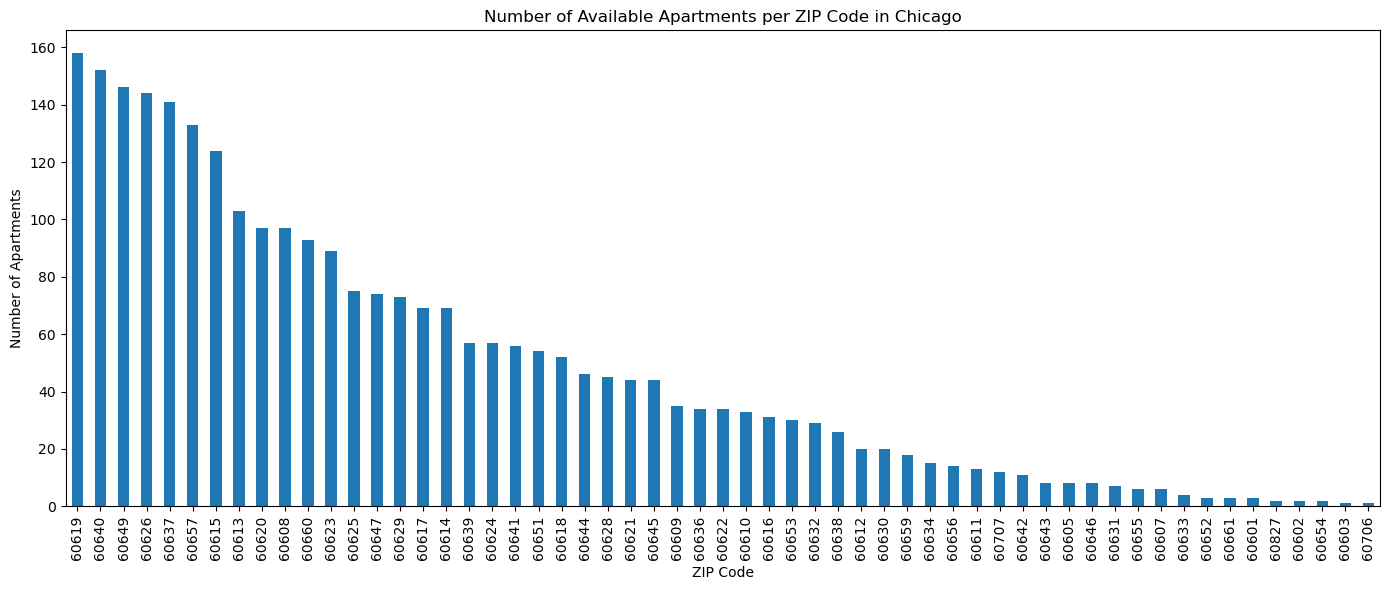

In [31]:
zip_counts = chicago_rentals_df['Zip'].value_counts().sort_values(ascending=False)

zip_counts.plot(kind='bar', figsize=(14,6))
plt.title('Number of Available Apartments per ZIP Code in Chicago')
plt.xlabel('ZIP Code')
plt.ylabel('Number of Apartments')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**What are the price distributions for available rentals in Chicago?** Most rental listings in the rental dataset fall between 1475.00 and 1650.00, which is shown below by looking at the tallest bars. This means that most rentals that are available in Chicago are at the upper end of a typical student's budget. The rental market at the moment heavily favors listings above $1200. This means that low cost options may be limited or harder to find. For higher priced rentals, a student may consider splitting the cost with roomates.

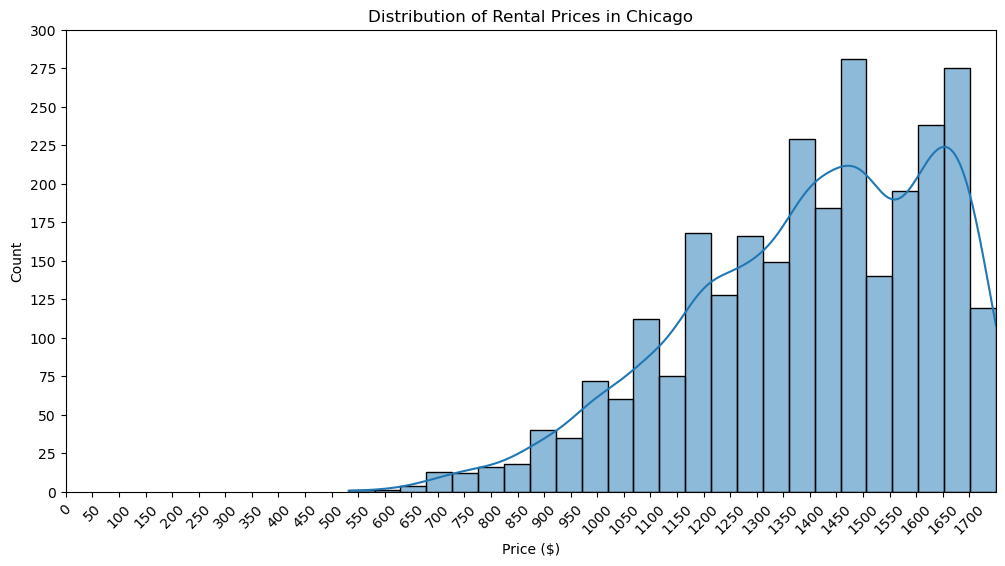

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(chicago_rentals_df['Price'], kde=True)
plt.title("Distribution of Rental Prices in Chicago")
plt.xlabel("Price ($)")
plt.ylabel("Count")        # How many listings fall within $ range

plt.yticks(ticks=np.arange(0, 325, 25))

plt.xlim(0, 1750)
plt.xticks(ticks=np.arange(0, 1750, 50), rotation=45)

plt.show()

In [50]:
chicago_rentals_df['Price'].describe()

count    2731.000000
mean     1403.049799
std       238.084687
min       532.000000
25%      1250.000000
50%      1445.000000
75%      1600.000000
max      1750.000000
Name: Price, dtype: float64

**What are the common bed listings?** Most common bed count in Chicago rentals are 1 and 2. There is also an increase of 0 bed count which means that the Chicago rental dataset contains about 600 studio apartments.

Text(0, 0.5, 'Count')

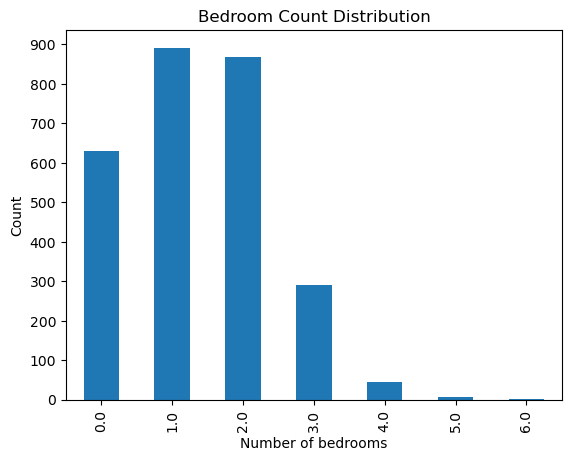

In [36]:
chicago_rentals_df['Beds'].value_counts().sort_index().plot(
    kind='bar',
    title='Bedroom Count Distribution'
)

plt.yticks(ticks=np.arange(0, 1000, 100))

plt.xlabel("Number of bedrooms")
plt.ylabel("Count")

In [154]:
bed_counts = chicago_rentals_df['Beds'].value_counts().sort_index()
bed_counts_df = bed_counts.reset_index()
bed_counts_df.columns = ['Number of Beds', 'Count']
display(bed_counts_df)

Number of Beds  Count
0             0.0    630
1             1.0    892
2             2.0    868
3             3.0    290
4             4.0     44
5             5.0      6
6             6.0      1

In [156]:
# This proves that it is true the dataset contains 630 studio apartments.
studio_count = chicago_rentals_df['Raw Property Details'].str.contains('studio', case=False, na=False).sum()
print(f"Number of studio apartments: {studio_count}")

Number of studio apartments: 630


# Visualizations

**Hypothesis 1**: Rental prices in Chicago increase with the number of bedrooms in an apartment. (Cristal Martinez)

When looking at the median price, it rises as the bed count increases, especially between 0 (studio), 1, 2, and 3 beds. Larger apartments tend to be more expensive, and there are fewer low priced options as the amount of bedrooms increase.

Studio apartments have a wider price range when looking at the graph below. Rents for studios span from 500 up to $1750. This suggests that 1–3 bed units are most common. Outliers exists within 2 bed and 3 bed listings and shows that there are some listing that are cheaper than typical.

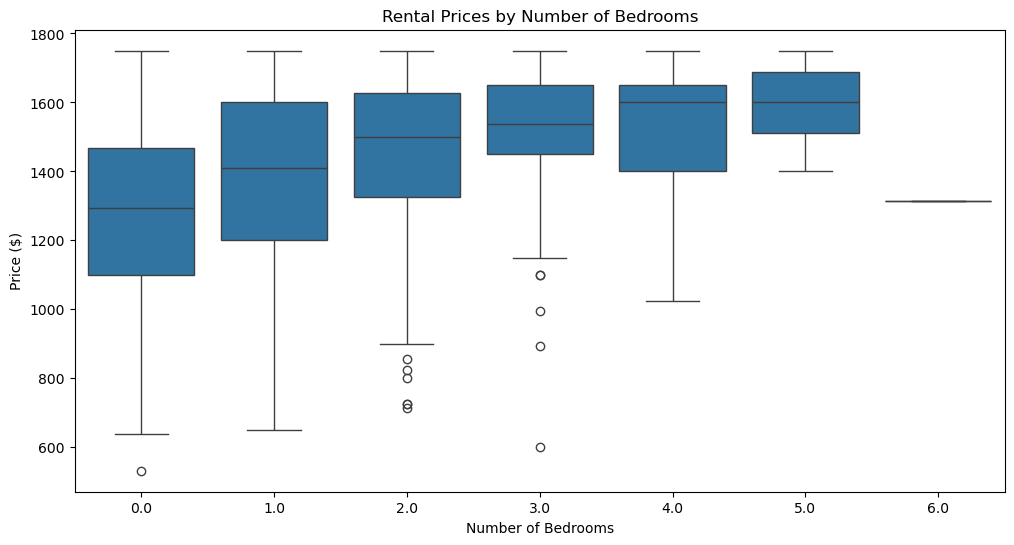

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Beds', y='Price', data=chicago_rentals_df)

plt.title("Rental Prices by Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price ($)")
plt.show()

**Hypothesis 2**: Apartments closer to Navy Pier tend to increase in price (Brandon Kim)

The coordinates for Navy Pier are 41.891900° latitude, -87.605100° longitude, according to Google. To calculate the "distance", we just used the distance formula on the coordinate values between the apartment coordinate values and Navy Pier's coordinates. 



While there seems to be no correlation between distance from Navy Pier and the price of an apartment, we may be missing some information.
For example, the price could be varied because of the many different types of apartments and what comes in each apartment(like rooms and how much sq feet), and these other features aren't accounted for in this graph.



<Axes: xlabel='distance', ylabel='Price'>

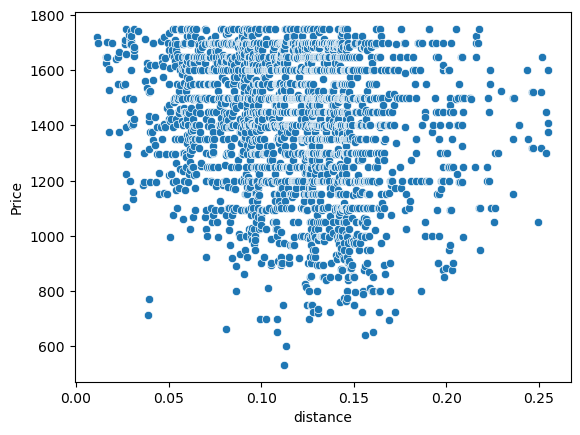

In [163]:
chicago_rentals_df1 = chicago_rentals_df
chicago_rentals_df2 = chicago_rentals_df1[['Price','Latitude','Longitude']].copy()
chicago_rentals_df2['distance'] = np.sqrt((abs(chicago_rentals_df2['Latitude'] - 41.891900) ** 2 )+ 
                                          (abs(chicago_rentals_df2['Longitude'] - -87.605100) ** 2))


chicago_rentals_df3 = chicago_rentals_df2.sort_values(by=['distance'])
chicago_rentals_df4 = chicago_rentals_df3.replace('nan', np.nan)
chicago_rentals_df5 = chicago_rentals_df4.dropna()

# chicago_rentals_df5


sns.scatterplot(x='distance', y='Price', data=chicago_rentals_df5)

# sns.boxplot(x='Beds', y='Price', data=chicago_rentals_df)



**Hypothesis 3**: Apartments closer to the university are higher in price in comparison to apartment listings farther away from University. (Tyler Yuen)

By utilizing the **haversine formula** which takes into account the radius of the earth, along with latitude and longitude to accurately predict the amount of (in our case) miles it takes from one point to another.

In [166]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, long1, lat2, long2):
    R = 3963.19
    # lat1, long1, lat2, long2 = map(np.radians, [lat1, long1, lat2, long2])
    lat1 = np.radians(lat1)
    long1 = np.radians(long1)
    lat2 = np.radians(lat2)
    long2 = np.radians(long2)

    dlong = long2 - long1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

school_name = "University of Illinois Chicago"
university = geocoded_colleges_df[geocoded_colleges_df['Name'] == school_name].copy()
# university_lat = university['Latitude']
# university_long = university['Longitude']

# Copy of all the chicago rentals only including price address latitude and longitude
apartments_distance_df = chicago_rentals_df[['Price', 'Address', 'Latitude', 'Longitude']].copy()
apartments_distance_df.head()

universities = geocoded_colleges_df.sample(n=3).copy()
universities = pd.concat([university, universities], ignore_index=True)
universities

Name  \
0             University of Illinois Chicago   
1  Toyota Technological Institute at Chicago   
2            American Academy of Art College   
3                   Chicago State University   

                                            Address   Latitude  Longitude  
0             601 S Morgan, Chicago, Illinois 60607  41.873779 -87.651001  
1   6045 S. Kenwood Avenue, Chicago, Illinois 60637  41.784730 -87.592465  
2  332 S Michigan Ave, Chicago, Illinois 60604-4302  41.877797 -87.624148  
3  9501 S. King Drive, Chicago, Illinois 60628-1598  41.717005 -87.609533

After successfully sampling University of Illinois Chicago as a first data point and 3 other random schools, we will be creating separate dataframes for each school where it adds a column 'distance' signifying the amount of miles between the respective school and apartment listings

In [169]:
# function to calculate distance in miles from the university to the apartment listing and then insert distance column
def calculateAndInsertDistance(df, university):
    df['distance'] = df.apply(lambda x: haversine(x['Latitude'], x['Longitude'], university['Latitude'], university['Longitude']), axis=1)

# apartments_distance_df['distance'] = apartments_distance_df.apply(lambda x: haversine(x['Latitude'], x['Longitude'], university_lat, university_long), axis=1)
distance_to_university_df = apartments_distance_df.copy()
distance_to_university_df_2 = apartments_distance_df.copy()
distance_to_university_df_3 = apartments_distance_df.copy()
distance_to_university_df_4 = apartments_distance_df.copy()

calculateAndInsertDistance(distance_to_university_df, universities.iloc[[0]])
calculateAndInsertDistance(distance_to_university_df_2, universities.iloc[[1]])
calculateAndInsertDistance(distance_to_university_df_3, universities.iloc[[2]])
calculateAndInsertDistance(distance_to_university_df_4, universities.iloc[[3]])

Let us take a quick look at how one of the dataframes will look

In [171]:
distance_to_university_df_4

Price                                            Address   Latitude  \
0      532.0              4713 N Western Ave, Chicago, IL 60625  41.967130   
1      600.0          6340 S Eberhart Ave #1, Chicago, IL 60637  41.779083   
2      639.0  Ferdinand, 5412 W Ferdinand St, Chicago, IL 60644  41.889187   
3      650.0            6115 S Drexel Ave #1, Chicago, IL 60637  41.783596   
4      650.0               158 N Central Ave, Chicago, IL 60644  41.883904   
...      ...                                                ...        ...   
2726  1750.0       4056 N Leamington Ave #2R, Chicago, IL 60641  41.954990   
2727  1750.0            3903 W Belden Ave #2, Chicago, IL 60647  41.922546   
2728  1750.0           5123 S Indiana Ave #3, Chicago, IL 60615  41.801254   
2729  1750.0              2653 N Harding Ave, Chicago, IL 60647  41.929714   
2730  1750.0              649 E Marquette Rd, Chicago, IL 60637  41.774788   

      Longitude   distance  
0    -87.688545  17.773986  
1    -87.613525   4.298944  
2    -87.761024  14.243021  
3    -87.603920   4.615269  
4    -87.765465  14.068683  
...         ...        ...  
2726 -87.756325  18.116717  
2727 -87.724594  15.405067  
2728 -87.620570   5.855349  
2729 -87.725480  15.880814  
2730 -87.608600   3.997205  

[2731 rows x 5 columns]

In my visualization, we will determine average prices based off of proximity from listings and sampled schools. For this case, we are picking University of Illinois at 3 other schools at random. This section will create a dataframe of our school samples.

Remember that our hypothesis revolves around the fact that close apartments are more expensive than apartments farther away so we will be doing groupings of apartments located in ranges of 0-2 miles away from the school ("short", "medium", "far"), 2-4 miles, and 4-6 miles.

In [173]:
price_near_df = pd.DataFrame(columns=['School', '0-2', '2-4', '4-6'])

def insertNearPrices(df, name):
    short = apartments_distance_df[(df['distance'] > 0) & (df['distance'] < 2)]
    medium = apartments_distance_df[(df['distance'] > 2) & (df['distance'] < 4)]
    far = apartments_distance_df[(df['distance'] > 4) & (df['distance'] < 6)]

    avg_price_near = short['Price'].mean()
    avg_price_near_2 = medium['Price'].mean()
    avg_price_near_3 = far['Price'].mean()

    price_near_df.loc[len(price_near_df)] = {'School': name, '0-2': avg_price_near, '2-4': avg_price_near_2, '4-6': avg_price_near_3}


insertNearPrices(distance_to_university_df, universities['Name'].iloc[0])
insertNearPrices(distance_to_university_df_2, universities['Name'].iloc[1])
insertNearPrices(distance_to_university_df_3, universities['Name'].iloc[2])
insertNearPrices(distance_to_university_df_4, universities['Name'].iloc[3])

price_near_df

School          0-2          2-4  \
0             University of Illinois Chicago  1538.967742  1468.412088   
1  Toyota Technological Institute at Chicago  1373.624679  1323.828125   
2            American Academy of Art College  1524.430769  1493.908000   
3                   Chicago State University  1233.800000  1333.687764   

           4-6  
0  1429.290323  
1  1364.346614  
2  1435.813218  
3  1355.529586

Below we are melting the corresponding sample schools in order to group them properly within a barplot

In [175]:
melted_df = pd.melt(price_near_df, id_vars=['School'], value_vars=['0-2', '2-4', '4-6'], var_name='Range', value_name='Price')
melted_df

School Range        Price
0              University of Illinois Chicago   0-2  1538.967742
1   Toyota Technological Institute at Chicago   0-2  1373.624679
2             American Academy of Art College   0-2  1524.430769
3                    Chicago State University   0-2  1233.800000
4              University of Illinois Chicago   2-4  1468.412088
5   Toyota Technological Institute at Chicago   2-4  1323.828125
6             American Academy of Art College   2-4  1493.908000
7                    Chicago State University   2-4  1333.687764
8              University of Illinois Chicago   4-6  1429.290323
9   Toyota Technological Institute at Chicago   4-6  1364.346614
10            American Academy of Art College   4-6  1435.813218
11                   Chicago State University   4-6  1355.529586

Here we are creating a grouped bar plot to show the different schools on the X axis, the price on the Y axis, and the different grouping within the x row are the average distance between apartment listings and the respective school

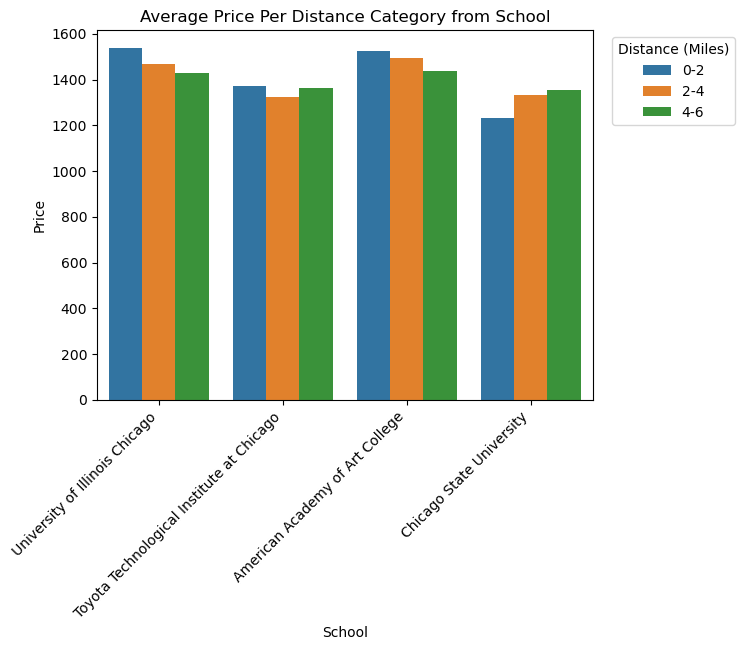

In [177]:
distances_plot = sns.barplot(x='School', y='Price', hue='Range', data=melted_df)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', title='Distance (Miles)')
plt.title("Average Price Per Distance Category from School")
plt.show()

This is ultimately an interesting hypothesis, which advances and plays off of Hypothesis 2, because it would make sense that apartments closer to campus will be sold at a higher price because you as the student get the luxury of living right next to school, in comparison to being farther away from the campus in which you have to have the hassle of making a long commute.

From our grouped barplot, we can see that there is significant drop in price the farther you get away from campus for the University of Illinois Chicago and Columbia College Chicago. Even for Chicago State City Colleges of Chicago - Harry S Truman College, one can see that the 2-4 mile medium range apartment listings are a little bit cheaper than apartment listings in the 0-2 mile range. Although it does have a contrast in that the 4-6 mile range is significantly higher, thus being an outlier. Lastly, Chicago State University is the biggest outlier in that the cheaper apartment listings are actually closer to their campus as opposed to the farther apartment listings.

One can conclude that based off of this visualization, while it may be true that apartment listings farther away from campus are cheaper, there may be more to it such as the quality of neighborhood, a good neighborhood causes price to increase, a bad neighborhood may cause price to decrease.

# ML Analysis

### ML Analysis 1

**Hypothesis 4**: (Manav Kohli)

A students personal preference such as Location of apartment listing and the number of bedrooms/bathrooms can accurately calculate and predict an prices of listings in Chicago

In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

=== Model Performance on Rent Prediction ===
Baseline (Mean) → RMSE: $54467.16, MAE: $193.54
Linear Regression → RMSE: $40312.34, MAE: $162.73
Random Forest → RMSE: $33183.01, MAE: $139.93


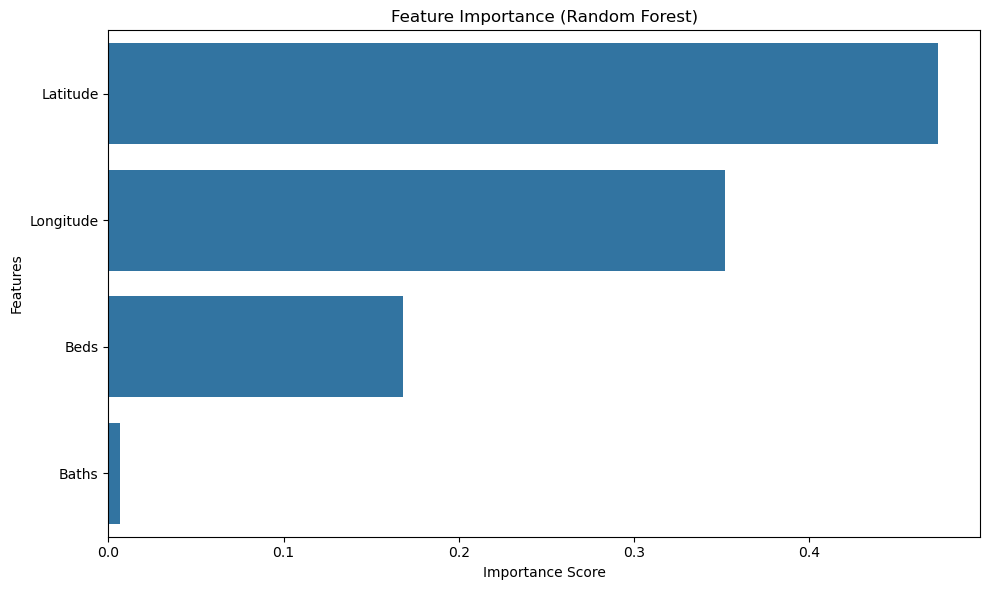

In [183]:
df = chicago_rentals_df
df['Beds'] = df['Beds'].astype(float)
df['Baths'] = df['Baths'].astype(float)
df = df[df['Price'].notnull() & (df['Price'] > 0)]


df['Zip'] = df['Zip'].astype(str)
df = pd.get_dummies(df, columns=['Zip'], drop_first=True)

df = df.dropna()

features = ['Beds', 'Baths', 'Latitude', 'Longitude']
target = 'Price'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1 : Baseline Model
mean_price = y_train.mean()
baseline_preds = [mean_price] * len(y_test)


# Model 2: Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Model 3: Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

def evaluate_model(name, true, pred):
    rmse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    print(f"{name} → RMSE: ${rmse:.2f}, MAE: ${mae:.2f}")

print("=== Model Performance on Rent Prediction ===")
evaluate_model("Baseline (Mean)", y_test, baseline_preds)
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)


importances = rf.feature_importances_
top_features = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### ML Analysis 2

**Hypothesis 5**: We can predict Rental price based on Public Transport Proximity for Apartments (Drew Vranicar)


One of the major challenges students face is finding affordable housing with convenient access to transportation. In this analysis, we examine whether an apartment's distance to the nearest Divvy station and CTA train stop can help predict its rent price.

The goal is to build a simple regression model to determine if transport proximity is a meaningful predictor of rental cost and whether students can prioritize access to Divvy and train lines when searching for housing.

We used geographic data to create two new features:

Distance_to_Divvy: Distance (in miles) to the nearest Divvy station
Distance_to_Train: Distance (in miles) to the nearest CTA train station

These were calculated using the Haversine formula.


A scatter plot was created to visually inspect the relationship between rent price and proximity to Divvy/train stations:

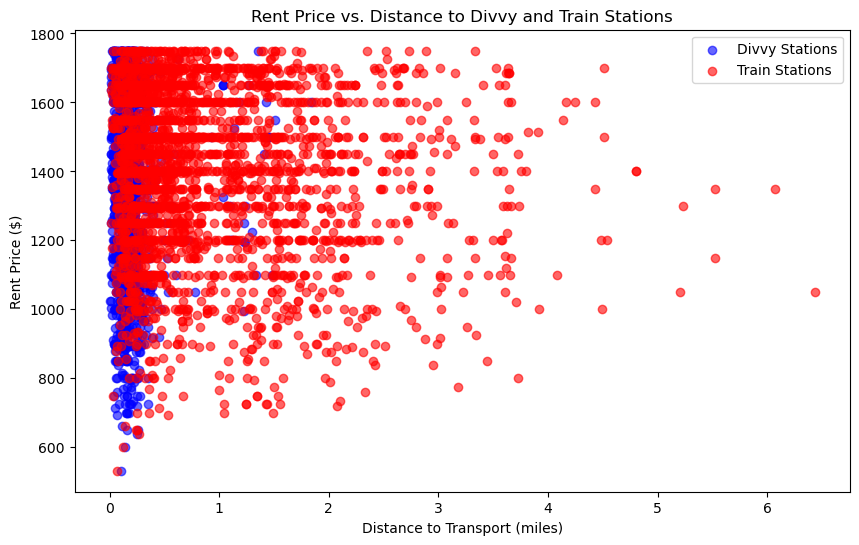

In [195]:
train_routes_df['Location'] = train_routes_df['Location'].astype(str).str.strip("()")
train_routes_df[['Latitude', 'Longitude']] = train_routes_df['Location'].str.split(',', expand=True)
train_routes_df['Latitude'] = train_routes_df['Latitude'].astype(float)
train_routes_df['Longitude'] = train_routes_df['Longitude'].astype(float)


# Defines distance functions

def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def min_distance(apartment_lat, apartment_lon, transport_df):
    return min([
        haversine(apartment_lat, apartment_lon, stop_lat, stop_lon)
        for stop_lat, stop_lon in zip(transport_df['Latitude'], transport_df['Longitude'])
    ])


# Ensures Latitude & Longitude columns are float in chicago_rentals_df

chicago_rentals_df['Latitude'] = chicago_rentals_df['Latitude'].astype(float)
chicago_rentals_df['Longitude'] = chicago_rentals_df['Longitude'].astype(float)


# Calculates Distance to Nearest Train Station

chicago_rentals_df['Distance_to_Train'] = chicago_rentals_df.apply(
    lambda row: min_distance(row['Latitude'], row['Longitude'], train_routes_df), axis=1
)


# Calculates Distance to Nearest Divvy Station
divvy_stations_df['Latitude'] = divvy_stations_df['Latitude'].astype(float)
divvy_stations_df['Longitude'] = divvy_stations_df['Longitude'].astype(float)

chicago_rentals_df['Distance_to_Divvy'] = chicago_rentals_df.apply(
    lambda row: min_distance(row['Latitude'], row['Longitude'], divvy_stations_df), axis=1
)

# Rent Price vs. Distance to Divvy and Train Stations

plt.figure(figsize=(10, 6))

plt.scatter(
    chicago_rentals_df['Distance_to_Divvy'], 
    chicago_rentals_df['Price'], 
    color='blue', alpha=0.6, label='Divvy Stations'
)

plt.scatter(
    chicago_rentals_df['Distance_to_Train'], 
    chicago_rentals_df['Price'], 
    color='red', alpha=0.6, label='Train Stations'
)

plt.xlabel('Distance to Transport (miles)')
plt.ylabel('Rent Price ($)')
plt.title('Rent Price vs. Distance to Divvy and Train Stations')
plt.legend()
plt.show()


The plot shows wide variability in price regardless of distance, supporting the finding that transport alone is not enough to explain rent.

# Reflection

The most challenging part of the project so far has been trying to calculate the distances based on a mix of addresses and coordinates in our different tables of data. We were able to use the geopy library to obtain coordinate values(latitude and longitude) from the addresses of locations such as the univerities and transportation routes.


Our initial insights of the project has been that our project will help students like us find apartments 
relatively quickly that are as close as possible to our university and within our price range. We are still processing 
information for the most part, but see a path to make the calculations possible. Calculating accurate distances seems to the crucial for our application to be helpful.

Concrete Results: Our data has been collected. We have data for the apartments, universities, bike divvy stops, bus stops, and train routes in Chicago. Our team was also able to use the geopy library in order to convert addresses and all other data into coordinates to be able to use consistent units in our calculations. 

Current Biggest Problems: Our current biggest problem is calculating accurate distances for travel because the transportation routes aren't in a straight line. This would involve using routing or Google Maps API in order to integrate the bus,train, and bike routes.

We are on track to finish our project. We are working to get our calculations finished.

It is worth continuing with our project. Moving forward, calculating distances based on the specific routes would be more beneficial to our project then just the straight line distance.

# Next Step

The next step for our project is to create a user interface where the user can input their data, which will help the application calculate accurate distances between universities, apartments, and transportation routes to present the final results.